# Tensor Flow with High density, trained with weighted Loss function

In [1]:
from heptrkx.postprocess.evaluate_tf import create_evaluator

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from graph_nets import utils_np
from trackml.dataset import load_event

from heptrkx.nx_graph.utils_plot import plot_networkx
from heptrkx.nx_graph.utils_data import correct_networkx
from heptrkx.nx_graph.utils_data import merge_truth_info_to_hits


import os
import glob

W0916 15:29:22.849529 46912496622976 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 15:29:22.852100 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0916 15:29:22.872922 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.local/lib/python3.6/site-packages/graph_nets/blocks.py:474: The name tf.unsorted_segment_sum is deprecated. Please use tf.math.unsorted_segment_sum instead.



In [2]:
config_file = '../configs/nxgraph_default.yaml'
input_ckpt = '/global/cscratch1/sd/xju/heptrkx/trackml/trained_results/nxgraph_big_007/bak'
iteration = 89908
# input_ckpt = '../trained_results/nxgraph_big_007'
# iteration = 109680

model = create_evaluator(config_file, iteration, input_ckpt)

W0916 15:29:23.452665 46912496622976 deprecation_wrapper.py:119] From /global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/postprocess/evaluate_tf.py:35: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0916 15:29:23.455327 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/base.py:212: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W0916 15:29:23.458827 46912496622976 deprecation_wrapper.py:119] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/base.py:294: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Total Events: 260 with 16 sections, total 4160 files 
Training data: [0, 207] events, total 3328 files
Testing data:  [208, 260] events, total 832 files
Training and testing graphs are selected randomly from their corresponding pools


W0916 15:29:23.994233 46912496622976 deprecation.py:506] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/basic.py:126: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0916 15:29:23.995295 46912496622976 deprecation.py:506] From /global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/sonnet/python/modules/basic.py:131: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0916 15:29:24.548641 46912496622976 deprecation_wrapper.py:119] From /global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/postprocess/evaluate_tf.py:4

In [3]:
file_dir = '/global/homes/x/xju/work/heptrkx/trackml/outputs/nxgraphs_big_000'
hits_graph_dir = '/global/homes/x/xju/atlas/heptrkx/data/hitgraphs_big_000'
trk_dir = '/global/homes/x/xju/atlas/heptrkx/trackml_inputs/train_all'

base_dir =  os.path.join(file_dir, "event00000{}_g{:09d}_INPUT.npz")

In [4]:
file_dir = '/global/cscratch1/sd/xju/heptrkx/data/nxgraphs_big_000'
hits_graph_dir = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_big_000'
trk_dir = '/global/homes/x/xju/atlas/heptrkx/trackml_inputs/train_all'

base_dir =  os.path.join(file_dir, "event00000{}_g{:09d}_INPUT.npz")

In [5]:
evtid = 1391
isec = -1
batch_size = 2

In [6]:
file_names = []
if isec < 0:
    section_patten = base_dir.format(evtid, 0).replace('_g{:09}'.format(0), '*')
    n_sections = int(len(glob.glob(section_patten)))
    file_names = [(base_dir.format(evtid, ii), ii) for ii in range(n_sections)]
else:
    file_names = [(base_dir.format(evtid, isec), isec)]

In [7]:
n_batches = len(file_names)//batch_size if len(file_names)%batch_size==0 else len(file_names)//batch_size + 1
split_inputs = np.array_split(file_names, n_batches)

ValueError: number sections must be larger than 0.

In [ ]:
dd = os.path.join(trk_dir, 'event{:09d}')
hits, particles, truth = load_event(dd.format(evtid), parts=['hits', 'particles', 'truth'])
hits = merge_truth_info_to_hits(hits, particles, truth)
true_features = ['pt', 'particle_id', 'nhits']

In [ ]:
%%time
all_graphs = []
is_digraph = True
is_bidirection = False
# evaluate each graph
for ibatch in range(n_batches):
    ## pad batch_size
    current_files = list(split_inputs[ibatch])
    if len(current_files) < batch_size:
        last_file = current_files[-1]
        current_files += [last_file] *(batch_size-len(current_files))

#     print(current_files)
    input_graphs = []
    target_graphs = []
    for items in current_files:
        file_name = items[0]
        with np.load(file_name) as f:
            input_graphs.append(dict(f.items()))

        with np.load(file_name.replace("INPUT", "TARGET")) as f:
            target_graphs.append(dict(f.items()))

    graphs = model(utils_np.data_dicts_to_graphs_tuple(input_graphs),
                   utils_np.data_dicts_to_graphs_tuple(target_graphs),
                   use_digraph=is_digraph, bidirection=is_bidirection
                  )
    if len(graphs) != batch_size:
        raise ValueError("graph size not the same as batch-size")

    # decorate the graph with truth info
    for ii in range(batch_size):
        idx = int(current_files[ii][1])
        id_name = os.path.join(hits_graph_dir, "event{:09d}_g{:03d}_ID.npz".format(evtid, idx))
        with np.load(id_name) as f:
            hit_ids = f['ID']

        for node in graphs[ii].nodes():
            hit_id = hit_ids[node]
            graphs[ii].node[node]['hit_id'] = hit_id
            graphs[ii].node[node]['info'] = hits[hits['hit_id'] == hit_id][true_features].values
        
        graphs[ii].graph['info'] = [idx] ## section ID

    all_graphs += graphs

#### Analyze these graphs. Edge features include 'predict' for predictions and 'solution' for truth

In [17]:
from heptrkx.nx_graph import utils_plot

In [18]:
import sklearn.metrics
fontsize=16
minor_size=14
def plot_metrics2(odd, tdd, odd_th=0.5, tdd_th=0.5, outname='roc_graph_nets.eps'):
    y_pred, y_true = (odd > odd_th), (tdd > tdd_th)
    accuracy  = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall    = sklearn.metrics.recall_score(y_true, y_pred)

    print('Accuracy:            %.4f' % accuracy)
    print('Precision (purity):  %.4f' % precision)
    print('Recall (efficiency): %.4f' % recall)

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, odd)


    fig, ax0 = plt.subplots(figsize=(6, 6), constrained_layout=True)

    # Plot the model outputs
    # binning=dict(bins=50, range=(0,1), histtype='step', log=True)
    binning=dict(bins=50, histtype='step', log=True)
    ax0.hist(odd[y_true==False], lw=2, label='fake', **binning)
    ax0.hist(odd[y_true], lw=2, label='true', **binning)
    ax0.set_xlabel('Model output', fontsize=fontsize)
    ax0.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
    ax0.set_xlim(0, 1)
    ax0.legend(loc=0, fontsize=fontsize)

    plt.savefig(outname)

Accuracy:            0.922460
Precision (purity):  0.475904
Recall (efficiency): 0.045018


/global/project/projectdirs/atlas/xju/heptrack/gnn/code/heptrkx/heptrkx/nx_graph/utils_plot.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(outname)
/global/homes/x/xju/.conda/envs/heptrk/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


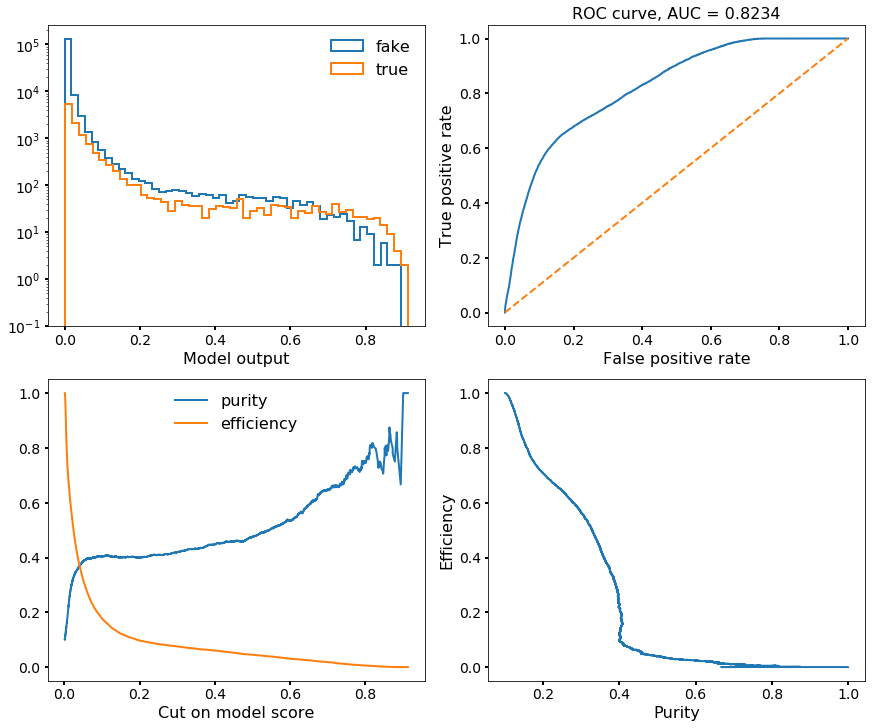

In [19]:
weights = []
truths = []
for G in all_graphs:
    weight = [G.edges[edge]['predict'][0] for edge in G.edges()]
    truth  = [G.edges[edge]['solution'][0] for edge in G.edges()]
    weights += weight
    truths += truth

    
weights = np.array(weights)
truths = np.array(truths)
utils_plot.plot_metrics(weights, truths, odd_th=0.5)
# plot_metrics2(weights, truths, odd_th=0.5)

Accuracy:            0.9934
Precision (purity):  0.9573
Recall (efficiency): 0.9593


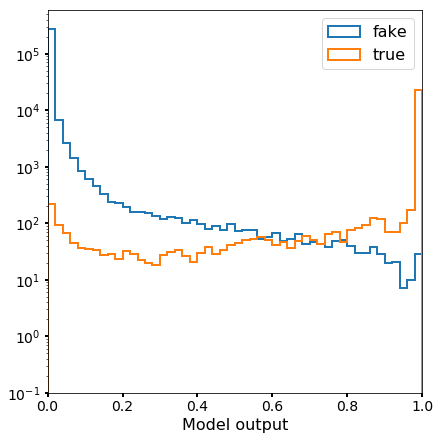

In [26]:
weights = []
truths = []
for G in all_graphs:
    weight = [G.edges[edge]['predict'][0] for edge in G.edges()]
    truth  = [G.edges[edge]['solution'][0] for edge in G.edges()]
    weights += weight
    truths += truth

    
weights = np.array(weights)
truths = np.array(truths)
utils_plot.plot_metrics(weights, truths, odd_th=0.5)
# plot_metrics2(weights, truths, odd_th=0.5)

Accuracy:            0.9837
Precision (purity):  0.8402
Recall (efficiency): 0.9820
Accuracy:            0.9936
Precision (purity):  0.9894
Recall (efficiency): 0.9295


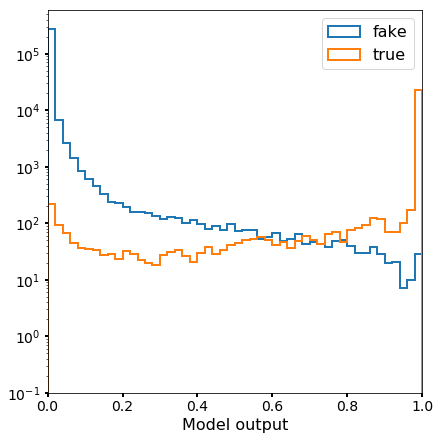

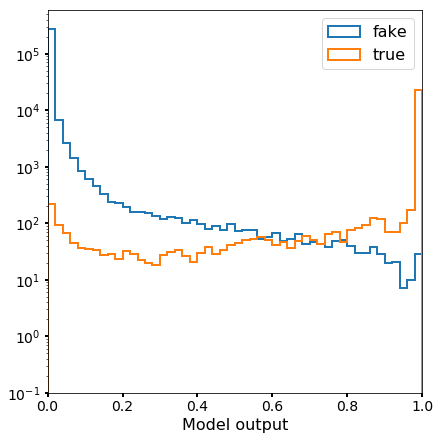

In [41]:
from nx_graph import utils_plot

Accuracy:            0.9934
Precision (purity):  0.9573
Recall (efficiency): 0.9593


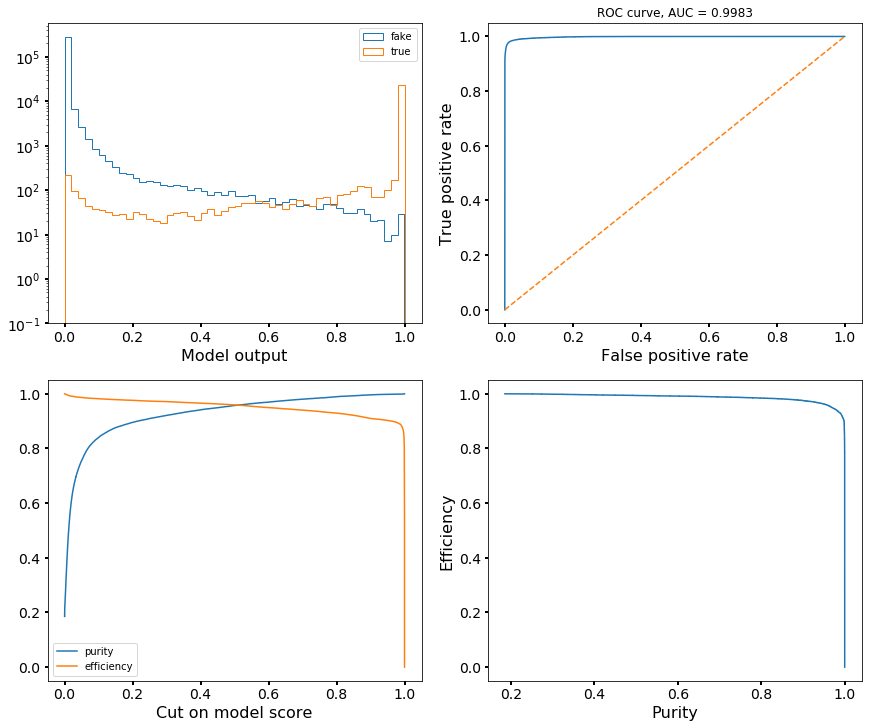

In [11]:
weights = []
truths = []
for G in all_graphs:
    weights += [G.edges[edge]['predict'][0] for edge in G.edges()]
    truths  += [G.edges[edge]['solution'][0] for edge in G.edges()]

    
weights = np.array(weights)
truths = np.array(truths)
utils_test.plot_metrics(weights, truths, odd_th=0.5)

In [29]:
from postprocess import wrangler, analysis

In [32]:
all_true_tracks = wrangler.get_tracks(G, feature_name='solution')
all_predict_tracks = wrangler.get_tracks(G, feature_name='predict')
true_df = analysis.graphs_to_df(all_true_tracks)
pred_df = analysis.graphs_to_df(all_predict_tracks)
total_particles = np.unique(true_df.merge(truth, on='hit_id', how='left')['particle_id'])
print(len(total_particles))

692


In [33]:
th = 0.

In [34]:
good_pids, bad_pids = analysis.label_particles(pred_df, truth, th, ignore_noise=True)
good_trks = hits[hits['particle_id'].isin(good_pids)]

In [1]:
def print_info(res_pred):
    print(res_pred['n_correct'], res_pred['n_wrong'], len(res_pred['isolated_pids']), len(res_pred['broken_pids']), len(res_pred['connected_pids']))

In [36]:
res_pred = analysis.summary_on_prediction(G, good_trks, pred_df)
print("Prediction Info")
print_info(res_pred)
print("True Info")
res_truth = analysis.summary_on_prediction(G, good_trks, true_df)
print_info(res_truth)

Prediction Info
279 352 1 71 281
True Info
286 345 1 71 274


In [37]:
279/286

0.9755244755244755

In [38]:
analysis.score_nxgraphs(all_true_tracks, truth)

[0.008535784588460535, 0.030574564, 0.01532867781497771, 0.02927782592450967]

In [39]:
analysis.score_nxgraphs(all_predict_tracks, truth)

[0.008442298843714063, 0.030574564, 0.01532867781497771, 0.02927782592450967]

In [40]:
0.008442298843714063/0.008535784588460535

0.9890477853819256

In [42]:
%%time
eff, purity, true_ones, fake_ones = analysis.trk_eff_purity(all_true_tracks, all_predict_tracks)
print("efficiency:", eff)
print("purity:", purity)

efficiency: 0.8707602339181286
purity: 0.9174368453481208
CPU times: user 3min 9s, sys: 172 ms, total: 3min 10s
Wall time: 3min 10s
